<a href="https://colab.research.google.com/github/TNTTNTTTN/Titanic_Survive_Prediction/blob/main/term_project_code_17011266_%EC%9D%B4%EC%88%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [385]:
#-*- coding: utf-8 -*-
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

seed = 3
np.random.seed(seed)
tf.random.set_seed(seed)

df1 = pd.read_csv("/content/train.csv")
df2 = pd.read_csv("/content/test.csv")
df1.drop(labels='Survived', axis=1, inplace=True)
df = pd.concat([df1, df2[:]], axis=0)
stscaler = StandardScaler()
mmscaler = MinMaxScaler()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


In [386]:
def get_title(Name):
  if 'Mrs' in Name or 'Mme' in Name :
    Title='Mrs'
  elif 'Mr' in Name or 'Sir' in Name :
    Title='Mr'
  elif 'Miss' in Name or 'Ms' in Name or 'Mlle' in Name:
    Title='Miss'
  elif 'Master' in Name:
    Title='Master'
  else:
    Title='Else'
  return Title

In [387]:
def classify_age(Age):
  if Age<=10 : tag ="0"
  elif Age <=20 : tag="1"
  elif Age <= 30 : tag="2"
  elif Age <= 40 : tag="3"
  elif Age <= 50 : tag="4"
  elif Age <= 60 : tag ="5"
  else : tag = "6"
  return tag

In [388]:
def classify_fare(Fare):
  if Fare <= 75 : tag="0"
  elif Fare <= 150 : tag=""
  elif Fare <= 225 : tag="2"
  elif Fare <= 300 : tag="3"
  elif Fare <= 375 : tag="4"
  elif Fare <= 450 : tag="5"
  else : tag = "6"
  return tag

In [389]:
df['Title'] = df['Name'].apply(lambda x : get_title(x))
df['Pclass'] = df['Pclass'].astype('string')
title_dic = {0:"Mrs", 1:"Mr", 2:"Miss", 3:"Master", 4:"Else"}
#df['Title'] = df['Title'].map(title_dic).astype(int).fillna(0)

In [390]:
df[df['Title']==3]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title


In [391]:
#df['Sex'] = df['Sex'].map({'male':0, 'female':1}).astype(int)
df.loc[(df['Sex']=='male') & (df['Age'].isnull()) & (df['Title']==title_dic[3]),'Age'] = 10
df.loc[(df['Sex']=='male') & (df['Age'].isnull()),'Age'] = df[df['Sex']=='male']['Age'].mean()
df.loc[(df['Sex']=='female') & (df['Age'].isnull()),'Age'] = df[df['Sex']=='female']['Age'].mean()
df['Age'] = df['Age'].apply(lambda x : classify_age(x))

In [392]:
df.loc[df['Fare'].isnull(),'Fare'] = df['Fare'].mean()

In [393]:
cabin_dic={'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6}
df['NCabin'] = df['Cabin'].fillna("N")
df['NCabin'] = df['NCabin'].str.extract('([A-Z])', expand=False)

In [394]:
df.groupby("NCabin")['Fare'].mean().sort_values()

NCabin
G     14.205000
F     18.079367
N     19.146674
T     35.500000
A     41.244314
D     53.007339
E     54.564634
C    107.926598
B    122.383078
Name: Fare, dtype: float64

In [395]:
def cabin_estimator(i):
    if i<16:
        a = "G"
    elif i<30:
        a = "F"
    elif i<44:
        a = "A"
    elif i<50:
        a = "E"
    elif i<60:
        a = "D"
    elif i<110:
        a = 'C'
    else:
        a = "B"
    return a
df['Cabin'] = df.Fare.apply(lambda x: cabin_estimator(x))

In [396]:
df['Family'] = df['SibSp']+df['Parch']
df.loc[df['Family'] > 3,'Family'] = 4
df['Family'] = df['Family'].astype('string')

In [397]:
embark_dic = {0:"C", 1:"S", 2:"Q"}
df['Embarked'].fillna(df['Embarked'].dropna().mode()[0], inplace=True)
for i in range(3):
  df.loc[(df['Pclass']==i+1) & (df['Fare'].isnull()),'Fare'] = df[df['Pclass']==i+1]['Fare'].dropna().median()
#df['Fare'].fillna(df['Fare'].dropna().median(), inplace=True)
#df['Fare'] = df['Fare'].apply(lambda x : classify_fare(x))

In [398]:
df[df['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,NCabin,Family


In [399]:
df['Sex'].value_counts()

male      843
female    466
Name: Sex, dtype: int64

In [400]:
stscaler.fit(df[['Fare']])
scaled = stscaler.transform(df[['Fare']])
mmscaler.fit(scaled)
output = mmscaler.transform(scaled)
output = pd.DataFrame(output, columns=['Fare'])
#df['Age'] = output['Age']
df['Fare'] = output['Fare']
#df['Ncabin'] = df['Ncabin'].astype(int)

KeyboardInterrupt: ignored

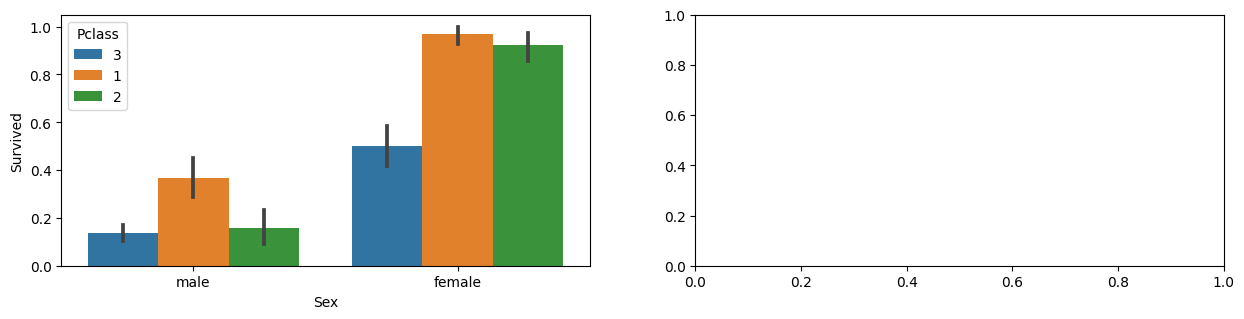

In [108]:
plt.figure(figsize=(15,15))
plt.subplot(4,2,1)
sns.barplot(x='Sex', y='Survived', hue='Pclass', data=df)
plt.subplot(4,2,2)
sns.barplot(x='Age', y='Survived', hue='Sex', data=df)
plt.subplot(4,2,3)
sns.scatterplot(x='Age', y='Title', hue='Survived', data=df)
plt.subplot(4,2,4)
sns.barplot(x='Family', y='Survived', data=df)
plt.subplot(4,2,5)
sns.scatterplot(x='Embarked', y='Fare',hue='Survived', data=df)
plt.subplot(4,2,6)
sns.scatterplot(x='Age', y='Fare',hue='Survived', data=df)

In [401]:
df.drop(['PassengerId','Name', 'Ticket', 'SibSp','Parch'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   string 
 1   Sex       1309 non-null   object 
 2   Age       1309 non-null   object 
 3   Fare      1309 non-null   float64
 4   Cabin     1309 non-null   object 
 5   Embarked  1309 non-null   object 
 6   Title     1309 non-null   object 
 7   NCabin    1309 non-null   object 
 8   Family    1309 non-null   string 
dtypes: float64(1), object(6), string(2)
memory usage: 102.3+ KB


In [402]:
df.drop(['NCabin','Embarked', 'Sex'],axis=1,inplace=True)

In [236]:
#data = ['Pclass','Sex','Embarked','Title','Ncabin','Family']
data= ['Pclass','Sex','Family','Age']
for column in data:
  le = LabelEncoder()
  le = le.fit(df[column])
  df[column] = le.transform(df[column])
me = MinMaxScaler()
me = me.fit(df[data])
df[data] = me.transform(df[data])

In [372]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    string 
 2   Age       891 non-null    object 
 3   Fare      891 non-null    float64
 4   Cabin     891 non-null    object 
 5   Title     891 non-null    object 
 6   Family    891 non-null    string 
dtypes: float64(1), int64(1), object(3), string(2)
memory usage: 48.9+ KB


In [403]:
#Survive = df.iloc[:,0]
#df = pd.get_dummies(df.iloc[:,1:])
df = pd.get_dummies(df,drop_first=True)
#df = pd.concat([Survive, df],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Fare          1309 non-null   float64
 1   Pclass_2      1309 non-null   uint8  
 2   Pclass_3      1309 non-null   uint8  
 3   Age_1         1309 non-null   uint8  
 4   Age_2         1309 non-null   uint8  
 5   Age_3         1309 non-null   uint8  
 6   Age_4         1309 non-null   uint8  
 7   Age_5         1309 non-null   uint8  
 8   Age_6         1309 non-null   uint8  
 9   Cabin_B       1309 non-null   uint8  
 10  Cabin_C       1309 non-null   uint8  
 11  Cabin_D       1309 non-null   uint8  
 12  Cabin_E       1309 non-null   uint8  
 13  Cabin_F       1309 non-null   uint8  
 14  Cabin_G       1309 non-null   uint8  
 15  Title_Master  1309 non-null   uint8  
 16  Title_Miss    1309 non-null   uint8  
 17  Title_Mr      1309 non-null   uint8  
 18  Title_Mrs     1309 non-null  

In [363]:
df.head()

,Survived,Pclass_2,Pclass_3,Fare_0,Fare_2,Fare_3,Fare_6,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Family_1,Family_2,Family_3,Family_4
0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0
1,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0
2,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0
4,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0


In [404]:
dataset = df.values
X = dataset[:,1:]
Y = dataset[:,0]
n_fold = 5
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=3)
skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=5)
accuracy =[]

In [381]:
from keras import regularizers

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50)
#history = model.fit(X_train, Y_train, validation_split=0.2, epochs=1000, batch_size=5, verbose=1, 
#          callbacks=[early_stopping_callback])
#model.fit(X, Y, validation_split=0.2, epochs=1000, batch_size=5, verbose=1, 
#         callbacks=[early_stopping_callback])
for train, test in skf.split(X, Y):
    model = Sequential()
    model.add(Dense(1, input_dim=23, kernel_regularizer=regularizers.l2(0.001), activation='sigmoid'))
    #model.add(Dropout(0.25))
    #model.add(Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    #model.add(Dropout(0.25))
    #model.add(Dense(10, kernel_regularizer=regularizers.l2(0.001), activation='softmax'))
    #model.add(Dropout(0.25))
    #model.add(Dense(4, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    #model.add(Dropout(0.25))
    #model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.fit(X[train], Y[train], validation_split=0.2, epochs=1000, batch_size=16, callbacks=[early_stopping_callback])
    k_accuracy = "%.4f" % (model.evaluate(X[test], Y[test])[1])
    accuracy.append(float(k_accuracy))
print("\n %.f fold mean accuracy:" % n_fold, sum(accuracy)/n_fold)

Streaming output truncated to the last 5000 lines.
36/36 [==============================] - 0s 3ms/step - loss: 0.4297 - accuracy: 0.8260 - val_loss: 0.3987 - val_accuracy: 0.8462
Epoch 225/1000
36/36 [==============================] - 0s 3ms/step - loss: 0.4297 - accuracy: 0.8260 - val_loss: 0.3988 - val_accuracy: 0.8462
Epoch 226/1000
36/36 [==============================] - 0s 4ms/step - loss: 0.4296 - accuracy: 0.8260 - val_loss: 0.3988 - val_accuracy: 0.8462
Epoch 227/1000
36/36 [==============================] - 0s 3ms/step - loss: 0.4296 - accuracy: 0.8260 - val_loss: 0.3985 - val_accuracy: 0.8462
Epoch 228/1000
36/36 [==============================] - 0s 3ms/step - loss: 0.4296 - accuracy: 0.8260 - val_loss: 0.3985 - val_accuracy: 0.8462
Epoch 229/1000
36/36 [==============================] - 0s 3ms/step - loss: 0.4295 - accuracy: 0.8260 - val_loss: 0.3984 - val_accuracy: 0.8462
Epoch 230/1000
36/36 [==============================] - 0s 3ms/step - loss: 0.4297 - accuracy: 0.826

In [382]:
accuracy

[0.7933, 0.809, 0.7865, 0.8427, 0.8652]

In [383]:
from keras import regularizers
model = Sequential()
model.add(Dense(1, input_dim=23, kernel_regularizer=regularizers.l2(0.001), activation='sigmoid'))
#model.add(Dropout(0.25))
#model.add(Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
#model.add(Dropout(0.25))
#model.add(Dense(4, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
#model.add(Dropout(0.25))
#model.add(Dense(4, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
#model.add(Dropout(0.25))
#model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X, Y, epochs=400, batch_size=16, verbose=1)

Epoch 1/400
56/56 [==============================] - 1s 2ms/step - loss: 0.6449 - accuracy: 0.6465
Epoch 2/400
56/56 [==============================] - 0s 2ms/step - loss: 0.6244 - accuracy: 0.6599
Epoch 3/400
56/56 [==============================] - 0s 2ms/step - loss: 0.6061 - accuracy: 0.6678
Epoch 4/400
56/56 [==============================] - 0s 2ms/step - loss: 0.5897 - accuracy: 0.6857
Epoch 5/400
56/56 [==============================] - 0s 2ms/step - loss: 0.5752 - accuracy: 0.7071
Epoch 6/400
56/56 [==============================] - 0s 2ms/step - loss: 0.5625 - accuracy: 0.7295
Epoch 7/400
56/56 [==============================] - 0s 2ms/step - loss: 0.5510 - accuracy: 0.7374
Epoch 8/400
56/56 [==============================] - 0s 2ms/step - loss: 0.5409 - accuracy: 0.7553
Epoch 9/400
56/56 [==============================] - 0s 2ms/step - loss: 0.5317 - accuracy: 0.7632
Epoch 10/400
56/56 [==============================] - 0s 2ms/step - loss: 0.5235 - accuracy: 0.7755
Epoch 11/

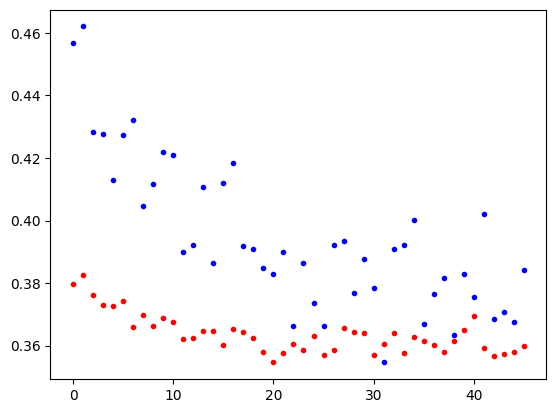

9/9 [==============================] - 0s 2ms/step - loss: 0.4571 - accuracy: 0.7873

 Accurarcy: 0.7873


In [ ]:
model_vloss = history.history['val_loss'][10:]
model_loss = history.history['loss'][10:]
x_len = np.arange(len(model_loss))

plt.plot(x_len, model_vloss, "o", c="red", markersize=3)
plt.plot(x_len, model_loss, "o", c="blue", markersize=3)
plt.show()

print("\n Accurarcy: %.4f" % (model.evaluate(X_test, Y_test)[1]))

In [405]:
model.save('please.h5')

In [406]:
model = load_model('please.h5')
Y_prediction = model.predict(dataset).flatten()




41/41 [==============================] - 0s 2ms/step


In [67]:
len(Y_prediction[891:])

418

In [407]:
submission = pd.read_csv('gender_submission.csv')
submission['Survived'] = Y_prediction[891:]
submission.loc[submission['Survived'] < 0.5 ,'Survived'] = 0
submission.loc[submission['Survived'] >= 0.5 ,'Survived'] = 1
submission['Survived'] = submission['Survived'].astype(int)
submission.to_csv('sub.csv',index=False)

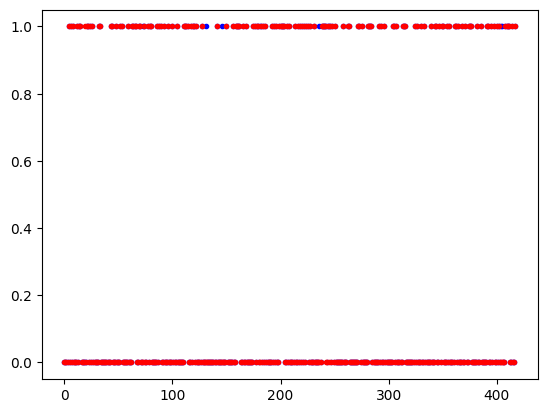

In [ ]:
#Y_prediction = model.predict(X_test).flatten()
osub = pd.read_csv("submit.csv")

Y_pred_old = osub['Survived']

#plt.plot(range(len(Y_test)), Y_test, "o", c="red", markersize=3)
plt.plot(range(len(Y_prediction)), submission['Survived'], "o", c="blue", markersize=3)
plt.plot(range(len(Y_prediction)), Y_pred_old, "o", c='red', markersize=3)
plt.show()

In [ ]:
t = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
pd.DataFrame(t).value_counts()

KeyError: ignored

In [ ]:
df['FBand'] = pd.cut(df['Fare'], 7)
df[['FBand','Survived']].groupby(['FBand'], as_index=False).mean()

In [ ]:
df['Ncabin'] = df['Cabin'].str.extract('([A-G])', expand=False)
pd.crosstab(df['Ncabin'],df['Survived'])

In [ ]:
df[['Embarked','Fare']].groupby(['Embarked'], as_index=False).mean()
df[['Pclass','Fare']].groupby(['Pclass'], as_index=False).mean()

In [ ]:
df.info()
df[df['Embarked'].isnull()]

In [ ]:

df[['Ncabin','Survived']].groupby('Ncabin').mean()

In [408]:
submit1 = pd.read_csv('sub.csv')
submit2 = pd.read_csv('sub(5).csv')

In [410]:
submit1[submit1['Survived'] == submit2['Survived']]

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
5,897,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
